In [1]:
import sys 
sys.path.append('../../../')
sys.path.append('../../')
sys.path.append('../')

from core.passive_learning import *
from core.auto_labeling import *
from utils.logging_utils import * 
from datasets import dataset_factory 
from datasets.dataset_utils import * 
from utils.counts import *  
from utils.common_utils import * 
from utils.vis_utils import *
from core.run_lib import * 
import copy 
import random 

config_file = '../../configs/arxiv-configs/Circles/active_labeling_Circles_linear_sklearn.yaml'
conf = load_yaml_config(config_file)

logger = get_logger('../../temp/logs/al.log','PL',level=logging.DEBUG)
#logger = get_logger('../../temp/logs/pl.log','PL')

train_conf = conf['training_conf']


print(train_conf)

{'train_set_frac': 0.1, 'loss_tolerance': 1e-05, 'max_epochs': 1000, 'normalize_weights': False, 'C': 1, 'stopping_criterion': 'val_err_threshold', 'val_err_threshold': 0.3, 'ckpt_load_path': 'None', 'ckpt_save_path': 'None', 'train_from_scratch': True, 'train_from_ckpt': False, 'ckpt_dir': './', 'probability': True}


In [2]:
C_1 = 0.25 
C = 2
ucb = 'sigma'

eps = 0.01

conf['training_conf']['C'] = 1

conf['auto_lbl_conf']['C_1'] = C_1 
conf['auto_lbl_conf']['ucb'] = ucb 
conf['auto_lbl_conf']['auto_label_err_threshold']=eps
conf['auto_lbl_conf']['N_V_max'] = 2000

conf['auto_lbl_conf']['score_type'] = "confidence"
 
#conf['training_conf']['probability'] = True 



conf['active_learning_conf']['margin_random_v2_constant'] = C 
conf['active_learning_conf']['query_batch_size'] = 8

# get data
ds = dataset_factory.load_dataset(conf)
ds.build_dataset()
train_set,val_set_std = randomly_split_dataset(ds,1- conf['data_conf']['val_fraction'])
# this val_set is the fixed val_set of big size. the algo will be given a subsample of it.

auto_lbl_conf = conf['auto_lbl_conf']

test_set = ds.get_test_datasets()
logger.info('Loaded dataset {}'.format(conf['data_conf']['dataset']))

human_labeling_helper = HumanLabelingHelper(train_set.X,train_set.Y)
n_q = 500

conf["random_seed"]=7
conf['max_query'] = n_q
conf['stopping_criterion']= "max_query"



[03/20/2023 03:10:58 PM MyLogger : INFO  : 161707255 : <cell line ] : Loaded dataset synth_concenteric_circles


In [3]:

set_seed(conf['random_seed'])
# get data
ds = dataset_factory.load_dataset(conf)
ds.build_dataset()
train_set,val_set_std = randomly_split_dataset(ds,1- conf['data_conf']['val_fraction'])
# this val_set is the fixed val_set of big size. the algo will be given a subsample of it.

auto_lbl_conf = conf['auto_lbl_conf']

#val_set_subset = val_set_std.get_random_fraction(auto_lbl_conf['initial_val_frac_for_auto_lbl'])

test_set = ds.get_test_datasets()
logger.info('Loaded dataset {}'.format(conf['data_conf']['dataset']))
logger.info('Unlabeled pool size: {} Validation Set Size:{}'.format(len(train_set),len(val_set_std)))

human_labeling_helper = HumanLabelingHelper(train_set.X,train_set.Y)

# full val_set_std is given to this method,
# it will start with initial_val_frac_for_auto_lbl fraction of this val_set_std
# and then query more if needed.

al = ActiveLabeling(conf, train_set, val_set_std, test_set, human_labeling_helper,train_set.Y,logger) 
lst_epoch_out = al.run_al_loop() 
logger.info('AL Loop Done')
#test_err = al.get_test_error(al.cur_clf,test_set,conf['inference_conf'])
out = al.get_counts(train_set,test_set)
#,"epoch_outs":lst_epoch_out


[03/20/2023 03:11:15 PM MyLogger : INFO  : 2680117431 : <cell line ] : Loaded dataset synth_concenteric_circles
[03/20/2023 03:11:15 PM MyLogger : INFO  : 2680117431 : <cell line ] : Unlabeled pool size: 8000 Validation Set Size:2000
[03/20/2023 03:11:15 PM MyLogger : DEBUG : active_lab : check_stop ] : Unlabeled Count In check_stop_criterion 8000
[03/20/2023 03:11:15 PM MyLogger : DEBUG : active_lab : check_stop ] : cur_query_count= 0 and max_query_count=500
[03/20/2023 03:11:15 PM MyLogger : DEBUG : active_lab : run_one_ep ] : -------------- BEGIN EPOCH 0 ------------
[03/20/2023 03:11:15 PM MyLogger : DEBUG : active_lab : run_one_ep ] : Number of Unalabeled Points  :8000
[03/20/2023 03:11:15 PM MyLogger : DEBUG : active_lab : run_one_ep ] : Querying 16 seed training points
[03/20/2023 03:11:15 PM MyLogger : DEBUG : active_lab : run_one_ep ] : Queried 16 seed points
[03/20/2023 03:11:15 PM MyLogger : DEBUG : active_lab : run_one_ep ] : Validation Data Size :2000
[03/20/2023 03:11:15 

In [4]:
from datasets.numpy_dataset import * 

In [33]:
lst_epoch_out[1].keys()

dict_keys(['unlabeled_pts_idcs', 'num_unlabeled', 'num_val_pts', 'val_data_budget_over', 'val_inf_out', 'lst_t_i_val', 'inf_out', 'lst_t_i', 'train_error', 'val_error', 'test_err', 'num_labeled', 'auto_lbld_idx_lbl', 'auto_labeling_err', 'auto_labeling_num', 'clf_weights', 'cur_clf', 'query_points', 'end_val_idcs'])

In [5]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(ax,epoch,lst_epoch_out,X,Y,inference_conf,calib=None):
    clf = lst_epoch_out[epoch]['cur_clf']
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = np.c_[xx.ravel(), yy.ravel()]
    ds = DatasetNumpy(X=Z)
    inf_out = al.run_inference(ds,clf,inference_conf,calib)

    #Z = Z.reshape(xx.shape)
    Z = inf_out['confidence']
    Y_hat = inf_out['labels']
    Z = (1 - Z)*(Y_hat==0) + Z*(Y_hat==1)  
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    #plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
    img = ax.pcolormesh(xx,yy,Z,cmap=plt.cm.RdBu)
    #plt.colorbar(img,ax)
    
    #plt.scatter(ds.X[:,0],ds.X[:,1],color='black')
    #plt.scatter(X[:, 0], X[:, 1],s=1,color='gray')
    
    epoch_out = lst_epoch_out[epoch]
    all_train_pts_till_epoch =[]
    all_train_pts_till_epoch.extend(lst_epoch_out[0]['seed_train_pts'])
    for e in range(epoch):
        all_train_pts_till_epoch.extend(lst_epoch_out[e]['query_points'])
    
    prev_qp, prev_qn = split_pos_neg_pts(all_train_pts_till_epoch,Y)
    ax.scatter(X[prev_qp,0],X[prev_qp,1],s=6.0,color='blue',label='prev. +ve queries')
    
    ax.scatter(X[prev_qp,0],X[prev_qp,1], s=50, facecolors='none',marker='o',edgecolors='b')
    ax.scatter(X[prev_qn,0],X[prev_qn,1],s=6.0,color='red',label='prev. -ve queries')
    ax.scatter(X[prev_qn,0],X[prev_qn,1], s=50, facecolors='none',marker='o',edgecolors='r')
    
    '''
    if('query_points' in epoch_out):
        q = epoch_out['query_points']
        qp,qn = split_pos_neg_pts(q,Y)
        ax.scatter(X[qp,0],X[qp,1],s=30.0,marker='x',color='blue',label='current +ve queries')
        ax.scatter(X[qn,0],X[qn,1],s=30.0,marker='x',color='red',label='current -ve queries')

        ax.scatter(X[qp,0],X[qp,1], s=65, facecolors='none',marker='s',edgecolors='b')

        ax.scatter(X[qn,0],X[qn,1], s=65, facecolors='none',marker='s',edgecolors='r')
    '''

    show_auto_lbld = True
    if(show_auto_lbld):
        #ax.scatter(X[:,0],X[:,1],marker='o',s=0.2,color='black')
        auto_lbleled_pts_till_now = [] 
        #auto_labeled_pts = epoch_out['auto_lbld_idx_lbl']
        
        for e in range(epoch+1):
            auto_lbleled_pts_till_now.extend(lst_epoch_out[e]['auto_lbld_idx_lbl'])

        auto_lbl_idx = [x[0] for x in auto_lbleled_pts_till_now]
        auto_lbl_Y   = [x[1] for x in auto_lbleled_pts_till_now]
        num_auto = len(auto_lbl_Y)
        qp = [ auto_lbl_idx[i] for i in range(num_auto) if int(auto_lbl_Y[i]) ==1 ]
        qn = [ auto_lbl_idx[i] for i in range(num_auto) if int(auto_lbl_Y[i]) ==0 ]
        print(len(qp),len(qn))
        ax.scatter(X[qp,0],X[qp,1],alpha=0.6,s=2.0,marker='.',color='blue',label='auto-labeled +ve')
        ax.scatter(X[qn,0],X[qn,1],alpha=0.6,s=2.0,marker='.',color='red', label='auto-labeled -ve')
    


[03/20/2023 03:19:56 PM MyLogger : INFO  : active_lab : run_infere ] : Running Uncalibrated Inference...
[03/20/2023 03:19:56 PM MyLogger : INFO  : active_lab : run_infere ] : Running Uncalibrated Inference...
0 1070


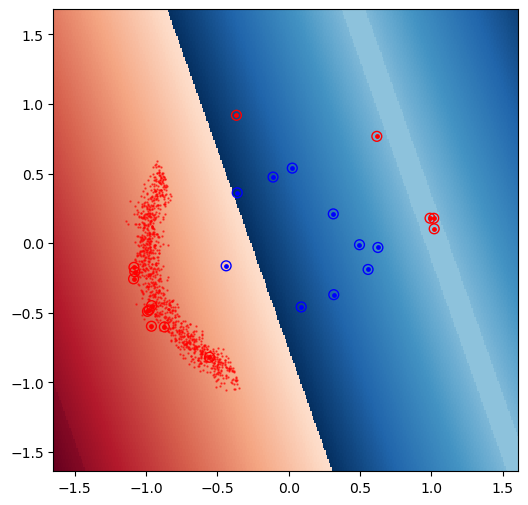

In [9]:
fig, ax = plt.subplots(figsize=(6,6))

plot_decision_boundary(ax,1,lst_epoch_out,train_set.X,train_set.Y,conf['inference_conf'])

In [14]:
xx,yy=np.meshgrid(np.arange(0, 10, 1), np.arange(0, 10, 1))
np.c_[xx.ravel(),yy.ravel()].shape 

(100, 2)

0.580104106419896


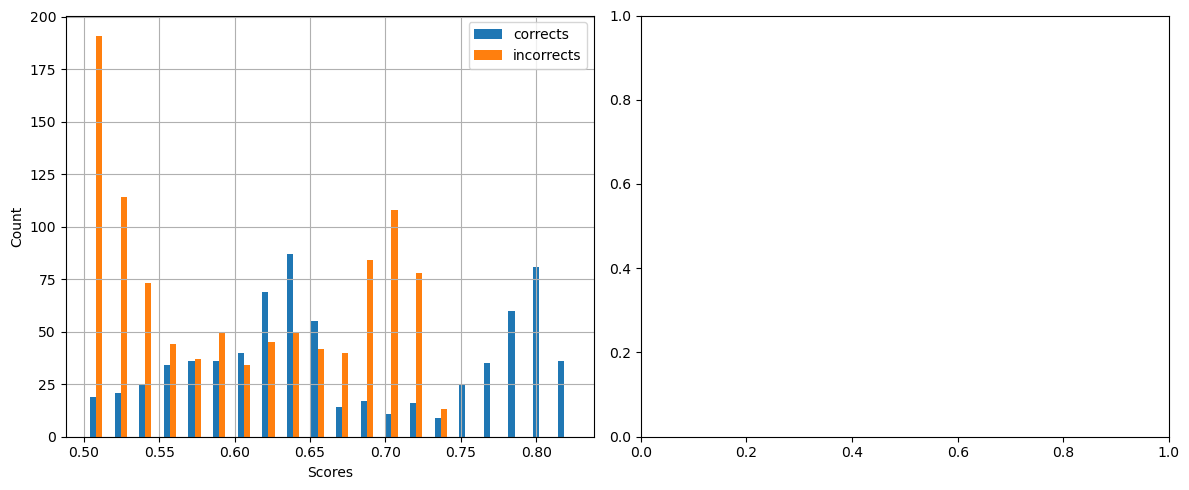

In [11]:

e = 2

o = lst_epoch_out[e]['val_inf_out']
m = len(o['confidence'])
S = np.zeros((m,5))
S[:,0] = o['confidence']
S[:,1] = o['labels'] 
S[:,2] = o['true_labels']
S[:,3] = S[:,1]==S[:,2]
#S[:,4] = o['energy_score']

S = S[(-S[:,4]).argsort()]
val_err = 1-sum(S[:,3])/m 
print(val_err)
logger = get_logger('../../temp/logs/pl.log','PL',level=logging.INFO)

fig,axs = plt.subplots(1,2,figsize=(12,5))

h = 0
bins = 20
#bins = [0,0.5,0.6,0.7,0.8,0.9,0.95,0.98,1]
labels = ['corrects','incorrects']
axs[0].hist([S[S[:,3]==1,h],S[S[:,3]==0,h]],bins=bins,rwidth=0.5, histtype ='bar',label=labels)
axs[0].legend()
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Scores')
axs[0].grid()
#axs[0].set_title('CIFAR-10 + Small CNN Net, Validation Error={}%'.format(val_err*100))
plt.tight_layout()

#save_path = f"{train_conf['ckpt_dir']}/active_label_histogram_round_{e}.pdf"

#plt.savefig(save_path,dpi=300, transparent=False, bbox_inches='tight')

#axs[1].set_title('CIFAR-10 + Small CNN Net, Validation Error={}%'.format(val_err*100))